In [2]:
import pandas as pd
import geopandas as gpd
import h3
import os
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
# !pip install descartes
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon

# Preparations for isochrones

Prep the network

In [2]:
# ## Takes 12 minutes

# # load the street network in Greater London
# G = ox.graph_from_place('Greater London, UK', network_type='walk')
# G = ox.project_graph(G, to_crs='EPSG:27700') # Project graph to British National Grid

# # export the graph to local as graphml
# ox.io.save_graphml(G, filepath=os.path.join('data','cleaned','G.graphml'))

In [3]:
# load graph from graphml, pre-created
G = ox.io.load_graphml(os.path.join('data','cleaned','G.graphml'))

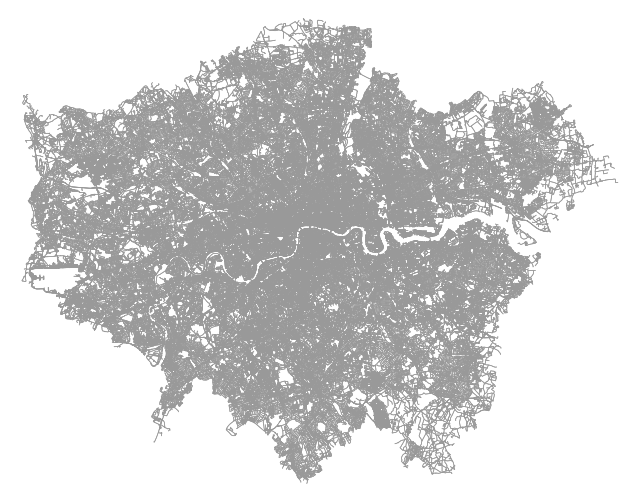

In [4]:
# plot the graph
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5, bgcolor='w', show=False, close=False)

Functions to find isochrone from single point

In [5]:
# Function to get isochrone polygons from a center node on a graph
def make_iso_polys(G, center_node, edge_buff=25, node_buff=50):
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        isochrone_polys = gpd.GeoSeries(all_gs).unary_union
    
    return isochrone_polys

# Wrapper Function to get isochrone from a point geometry
def get_isochrone_walk(point):
    
    global G
    x, y = point.x, point.y # Define point coords
    center_node = ox.nearest_nodes(G, x, y) # Find center node

    # get the isochrone polygons
    isochrone_polys = make_iso_polys(G, center_node, edge_buff=25, node_buff=0)
    
    return isochrone_polys

# Wrapper Function to plot isochrone
def plot_isochrone(point):

    global G
    x, y = point.x, point.y # Define point coords
    center_node = ox.nearest_nodes(G, x, y) # Find center node

    # get the isochrone polygons
    isochrone_polys = make_iso_polys(G, center_node, edge_buff=25, node_buff=0)

    # plot it
    iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0)
    fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,node_size=0, bgcolor='k')
    for polygon, fc in zip(isochrone_polys, iso_colors):
        patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
    plt.show()

# READ BUS_ISOCHRONE_15M

In [3]:
# read the bus isochrone polygons
bus_isochrone = gpd.read_file(os.path.join('data','cleaned','bus_isochrone_15m.gpkg'))

In [4]:
bus_isochrone.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18526 entries, 0 to 18525
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id_code   18526 non-null  object  
 1   name      18526 non-null  object  
 2   pt_type   18526 non-null  object  
 3   geometry  18526 non-null  geometry
dtypes: geometry(1), object(3)
memory usage: 579.1+ KB


# ADD TO BUS_ISOCHRONE_15M

In [ ]:
# import diff 
diff = gpd.read_file(os.path.join('data','bin','flow_bus_byStop_diff.gpkg'))
#rename
diff.rename(columns={'stop_id':'id_code','stop_name':'name'},inplace=True)
diff.drop(columns=['Total'],inplace=True)
diff['pt_type'] = 'bus'
diff.info()

In [ ]:
%%time 
# configure the place, network type, trip times, and travel speed
network_type = 'walk'
trip_times = [15] #in minutes

# takes a while to run 4.6/stop
# add isochrone polygons to flow_rail
diff['isochrone'] = diff.geometry.apply(get_isochrone_walk)
diff = diff.drop(columns='geometry')
diff.rename(columns={'isochrone':'geometry'},inplace=True)
diff = gpd.GeoDataFrame(diff, geometry='geometry', crs='EPSG:27700')
diff.info()

In [ ]:
# diff.to_file(os.path.join('data','bin','bus_isochrone_15m_diff.gpkg'), driver='GPKG')

In [6]:
# load diff bus isochrone
bus_isochrone_diff = gpd.read_file(os.path.join('data','bin','bus_isochrone_15m_diff.gpkg'))
bus_isochrone_diff.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id_code   46 non-null     object  
 1   name      46 non-null     object  
 2   pt_type   46 non-null     object  
 3   geometry  46 non-null     geometry
dtypes: geometry(1), object(3)
memory usage: 1.6+ KB


In [9]:
# concat the bus isochrone polygons
bus_isochrone_merge = pd.concat([bus_isochrone,bus_isochrone_diff],ignore_index=True)
bus_isochrone_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18572 entries, 0 to 18571
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id_code   18572 non-null  object  
 1   name      18572 non-null  object  
 2   pt_type   18572 non-null  object  
 3   geometry  18572 non-null  geometry
dtypes: geometry(1), object(3)
memory usage: 580.5+ KB


# FILTER TO ACTIVE ISCHORONES

In [13]:
# load flow_bus_byStop
flow_bus = gpd.read_file(os.path.join('data','cleaned','flow_bus_byStop.gpkg'))
flow_bus.rename(columns={'stop_id':'id_code','stop_name':'name'},inplace=True) # rename   
flow_bus.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 16942 entries, 0 to 16941
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id_code   16942 non-null  object  
 1   name      16942 non-null  object  
 2   Total     16942 non-null  float64 
 3   geometry  16942 non-null  geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 529.6+ KB


In [15]:
# filter out the isochrones with id_cdoe not in flow_bus
bus_isochrone_merge = bus_isochrone_merge[bus_isochrone_merge.id_code.isin(flow_bus.id_code)]
bus_isochrone_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 16942 entries, 0 to 18571
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id_code   16942 non-null  object  
 1   name      16942 non-null  object  
 2   pt_type   16942 non-null  object  
 3   geometry  16942 non-null  geometry
dtypes: geometry(1), object(3)
memory usage: 661.8+ KB


In [17]:
bus_isochrone_merge.head()

,id_code,name,pt_type,geometry
0,1000,Westminster Stn / Parliament Square,bus,"POLYGON ((529636.333 179490.928, 529635.867 17..."
1,10001,Trevor Close,bus,"POLYGON ((515097.144 174245.611, 515095.707 17..."
2,10002,Highbury Corner,bus,"POLYGON ((531241.731 184111.782, 531240.004 18..."
3,10003,Highbury & Islington Station,bus,"POLYGON ((531196.667 184463.996, 531195.515 18..."
4,10004,St Mary Magdalene Church,bus,"POLYGON ((530870.989 184605.442, 530870.254 18..."


In [16]:
# export the bus isochrone polygons
bus_isochrone_merge.to_file(os.path.join('data','cleaned','bus_isochrone_15m.gpkg'), driver='GPKG')